In [1]:
import pyqg
import icechunk as ic
import xarray as xr
import zarr
import threading
import queue

In [2]:
storage = ic.s3_storage(
    bucket="icechunk-test",
    prefix="dvc-webinar/pyqg-demo-2/",
)
repo = ic.Repository.create(storage)
repo

In [3]:
# create root group
session = repo.writable_session("main")
zarr.group(session.store, zarr_format=3)
session.commit("created_root_group")

'PPMBH8J5QJD01GK20F10'

In [4]:
beta = beta=1.5e-11
rd = 15000.0
run_name = f'beta={int(beta * 1e12)},rd={int(rd / 1000)}'
run_name

'beta=15,rd=15'

In [5]:
year = 24*60*60*360.
m = pyqg.QGModel(
    beta=beta, rd=rd,
    tmax=10*year, twrite=10000,
    tavestart=1e99 # never average
)
m.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 3.69e-04, CFL: 0.086
INFO: Step: 20000, Time: 1.44e+08, KE: 5.10e-04, CFL: 0.089
INFO: Step: 30000, Time: 2.16e+08, KE: 4.52e-04, CFL: 0.084
INFO: Step: 40000, Time: 2.88e+08, KE: 4.63e-04, CFL: 0.088


In [6]:
ds = m.to_dataset()
ds

<xarray.Dataset> Size: 799kB
Dimensions:  (time: 1, lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
  * time     (time) float64 8B 3.11e+08
  * lev      (lev) int64 16B 1 2
  * lev_mid  (lev_mid) float64 8B 1.5
  * x        (x) float64 512B 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y        (y) float64 512B 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * l        (l) float64 512B 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k        (k) float64 264B 0.0 6.283e-06 1.257e-05 ... 0.0001948 0.0002011
Data variables: (12/14)
    q        (time, lev, y, x) float64 66kB 4.374e-06 -4.69e-08 ... 1.327e-06
    u        (time, lev, y, x) float64 66kB 0.05025 0.07883 ... -0.0005026
    v        (time, lev, y, x) float64 66kB 0.04696 0.04033 ... 0.003429
    ufull    (time, lev, y, x) float64 66kB 0.07525 0.1038 ... -0.0005026
    vfull    (time, lev, y, x) float64 66kB 0.04696 0.04033 ... 0.003429
    qh       (time, lev, l, k) complex128 68kB (0.0022324424347652627+0j) ......
    ...       ...
    ph       (time, lev, l, k) complex128 68kB 0j ... (-5.2607943854066586e-1...
    dqhdt    (time, lev, l, k) complex128 68kB (-0-0j) ... (-1.94474014962966...
    Ubg      (lev) float64 16B 0.025 0.0
    Qy       (lev) float64 16B 1.039e-10 -7.222e-12
    dqdt     (time, lev, y, x) float64 66kB -2.415e-12 -2.233e-12 ... -6.216e-13
    p        (time, lev, y, x) float64 66kB -908.4 -187.3 ... -679.6 -731.1
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         7200.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         43200
    pyqg:tmax:       311040000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

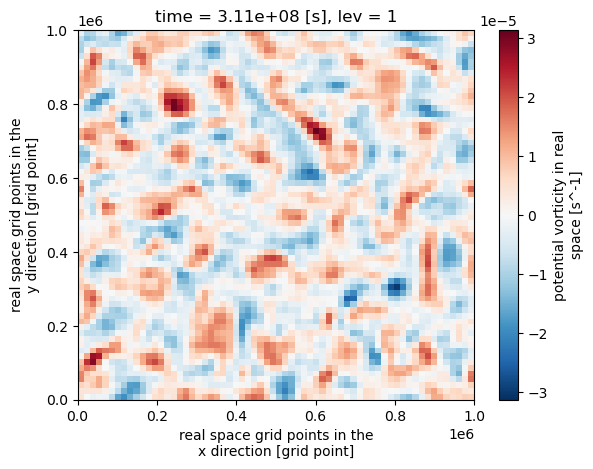

In [7]:
ds.q[0, 0].plot()

In [8]:
vars_to_keep = ['q']

In [9]:
session = repo.writable_session("main")
ds[vars_to_keep].to_zarr(session.store, group=run_name, zarr_format=3, consolidated=False)
session.commit(f"{run_name} - wrote initial snapshot @ t={m.t}")

'BA338MZRMR4XZMQHSJ60'

In [10]:
NSAMPLES=200

In [12]:
q = queue.Queue()
lock = threading.Lock()

def worker():
    while True:
        (ds, store, group_name) = q.get()
        # lock is probably unncessary
        with lock:
            ds.to_zarr(store, group=group_name, zarr_format=3, consolidated=False, append_dim="time")
        q.task_done()

# Turn-on the worker thread.
threading.Thread(target=worker, daemon=True).start()

session = repo.writable_session("main")

tsnapint = 24*60*60 * 30
m.tmax += NSAMPLES * tsnapint

for _ in m.run_with_snapshots(tsnapint=tsnapint):
    q.put((m.to_dataset()[vars_to_keep], session.store, run_name))

print(q.qsize())
q.join()

session.rebase(ic.ConflictDetector())
session.commit(f"{run_name} wrote data")

INFO: Step: 120000, Time: 8.64e+08, KE: 4.82e-04, CFL: 0.095
INFO: Step: 130000, Time: 9.36e+08, KE: 3.95e-04, CFL: 0.096
INFO: Step: 140000, Time: 1.01e+09, KE: 4.57e-04, CFL: 0.092
INFO: Step: 150000, Time: 1.08e+09, KE: 5.07e-04, CFL: 0.082
INFO: Step: 160000, Time: 1.15e+09, KE: 4.64e-04, CFL: 0.093
INFO: Step: 170000, Time: 1.22e+09, KE: 5.16e-04, CFL: 0.102
INFO: Step: 180000, Time: 1.30e+09, KE: 5.00e-04, CFL: 0.090


1


'05MT43VT7MMJP30G4BGG'

In [13]:
session = repo.readonly_session(branch="main")
ds = xr.open_dataset(session.store, group=run_name, engine="zarr", zarr_format=3, consolidated=False)
ds

<xarray.Dataset> Size: 26MB
Dimensions:  (x: 64, time: 401, lev: 2, y: 64)
Coordinates:
  * x        (x) float64 512B 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * time     (time) float64 3kB 3.11e+08 3.136e+08 ... 1.345e+09 1.348e+09
  * lev      (lev) int64 16B 1 2
  * y        (y) float64 512B 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Data variables:
    q        (time, lev, y, x) float64 26MB ...
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  1e+99
    pyqg:tc:         187200
    pyqg:tmax:       1347840000.0
    pyqg:twrite:     10000
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

In [ ]:
! aws s3 rm --recursive s3://icechunk-test/dvc-webinar/pyqg-demo-2/